In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# New Section

In [2]:
def plot_casing_setting_depths(ax, fracture_pressure, pore_pressure, TVD_frac, TVD_pore, 
                               fracture_pressure_safety=None, pore_pressure_safety=None,
                               casing_seats_ppg=None, casing_seats_tvd=None):
    
    ax.set_title("Casing Setting Depths", fontsize=30, y=1.08)

    label_size = 12
    
    ax.plot(fracture_pressure, TVD_frac, color="red", linewidth=3, label="Fracture Pressure")
    ax.plot(pore_pressure, TVD_pore, color="blue", linewidth=3, label="Pore Pressure")
    if fracture_pressure_safety is not None:
        ax.plot(fracture_pressure_safety, TVD_frac, color="red", linewidth=3, label="Safe Fracture Pressure", linestyle="--")

    if pore_pressure_safety is not None:
        ax.plot(pore_pressure_safety, TVD_pore, color="blue", linewidth=3, label="Safe Pore Pressure", linestyle="--")

    if casing_seats_ppg is not None and casing_seats_tvd is not None:
        ax.plot(casing_seats_ppg, casing_seats_tvd, color="black", linestyle="--", linewidth=3, label="Casing Seats")

    ax.set_ylabel("Total Vertical Depth [ft]", fontsize=25)
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")

    yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
    xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
    ax.set_xlabel("Equivalent Mud Density [ppg]", fontsize=25)
    #ax.ticklabel_format(fontsize=25)
    ax.grid()
    ax.legend(fontsize=20)

In [3]:
data = pd.read_excel('RX-16_Geomechanical-Output_TVDKBmm (1).xlsx',sheet_name='Curves')
data.head()

,DEPTH,PPG,FG,PP,FP
0,44.4,0.034,1.407,0.078499,3.248482
1,44.9,0.153,1.494,0.357224,3.488191
2,45.4,0.269,1.533,0.635055,3.619106
3,45.9,0.381,1.559,0.909371,3.721021
4,46.4,0.491,1.584,1.184685,3.821875


In [4]:
TVD_pore = data['DEPTH']
TVD_frac = data['DEPTH']
fracture_pressure = data['FG']
pore_pressure = data['PPG']


In [5]:
percent_safety = 3. # 3% Safety margin
safety = percent_safety/100. 
fracture_pressure_safety = (1.-safety)*fracture_pressure
pore_pressure_safety = (1.+safety)*pore_pressure
pore_pressure_safety=pore_pressure_safety.tolist()
fracture_pressure_safety=fracture_pressure_safety.tolist()
pore_pressure=pore_pressure.tolist()
fracture_pressure=fracture_pressure.tolist()
TVD_frac=TVD_frac.tolist()
TVD_pore=TVD_pore.tolist()

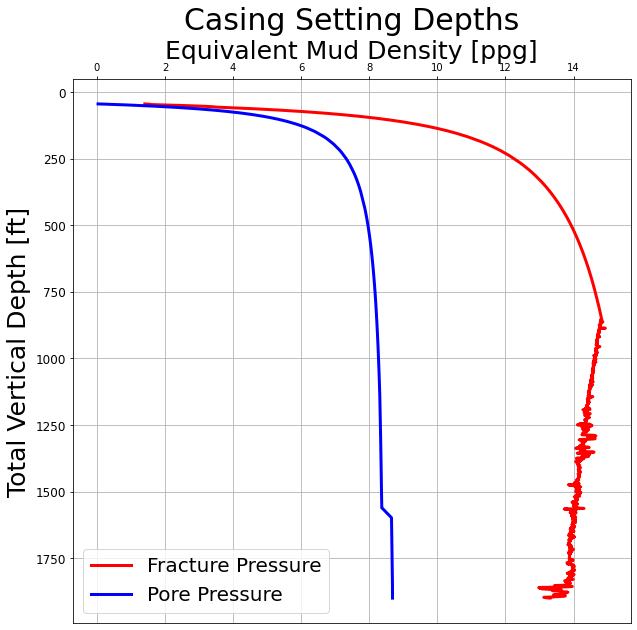

In [6]:
fig, ax = plt.subplots(1, figsize=(10, 10))
plot_casing_setting_depths(ax, fracture_pressure, pore_pressure, TVD_frac, TVD_pore)


In [7]:
def bottom_up_casing_seat(pore_pressure, fracture_pressure, tvd_pore, tvd_frac,
                          previous_section_mud_weight):
    next_section_tvd = np.interp(previous_section_mud_weight, fracture_pressure, tvd_frac)
    next_section_mud_weight = np.interp(next_section_tvd, tvd_pore, pore_pressure)
    return next_section_mud_weight, next_section_tvd

In [8]:
def find_casing_seats(pore_pressure, fracture_pressure, tvd_pore, tvd_frac, 
                      maxiter=5):
    current_mud_weight = pore_pressure[-1]
    current_depth = tvd_pore[-1]
    casing_seats = []
    i = 0
    while current_depth > 0.0 and i < maxiter:
        next_section_mud_weight, next_section_tvd = bottom_up_casing_seat(pore_pressure, fracture_pressure, 
                                                                          tvd_pore, tvd_frac, 
                                                                          current_mud_weight)
        casing_seats.append((next_section_tvd, next_section_mud_weight))
        current_depth, current_mud_weight = next_section_tvd, next_section_mud_weight
        i += 1
    return casing_seats

In [9]:
def get_casing_seat_plot_data(pore_pressure, tvd_pore, casing_seats):
    casing_seats_tvd = [tvd_pore[-1], casing_seats[0][0]]
    casing_seats_ppg = [pore_pressure[-1], pore_pressure[-1]]

    for p1, p2 in zip(casing_seats, casing_seats[1::]):
        casing_seats_tvd.append(p1[0])
        casing_seats_tvd.append(p2[0])

    for p1, p2 in zip(casing_seats, casing_seats):
        casing_seats_ppg.append(p1[1])
        casing_seats_ppg.append(p2[1])
      
    return casing_seats_tvd, casing_seats_ppg[0:-2]

In [10]:
casing_seats = find_casing_seats(pore_pressure_safety, fracture_pressure_safety, TVD_pore, TVD_frac)
casing_seats_tvd, casing_seats_ppg = get_casing_seat_plot_data(pore_pressure_safety, TVD_pore, casing_seats)
print(casing_seats_tvd)
print(casing_seats_ppg)

[1899.4, 116.81506051098165, 116.81506051098165, 73.85447025216214, 73.85447025216214, 59.88754401300576, 59.88754401300576, 51.54223231751094, 51.54223231751094, 45.88828076225258]
[8.94349, 8.94349, 5.944945320484089, 5.944945320484089, 4.031133513900344, 4.031133513900344, 2.7125360993407197, 2.7125360993407197, 1.5116388816480202, 1.5116388816480202]


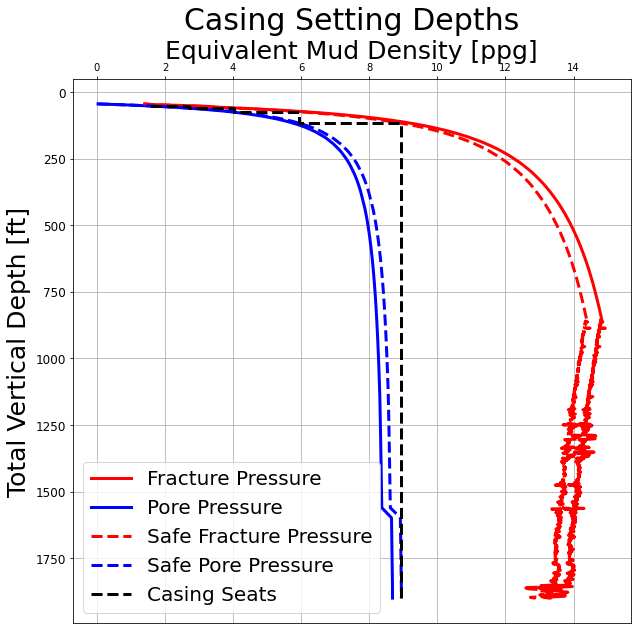

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 10))
plot_casing_setting_depths(ax, fracture_pressure, pore_pressure, TVD_frac, TVD_pore,
                           fracture_pressure_safety=fracture_pressure_safety,
                           pore_pressure_safety=pore_pressure_safety,
                           casing_seats_ppg=casing_seats_ppg, casing_seats_tvd=casing_seats_tvd)